## Phase II: Data Curation, Exploratory Analysis and Plotting
### How Has Nutritional Value in Processed Food Changed Over Time?

#### DS 3000
#### Name: Steven Yu, Jason Lo, Jennifer Nguyen

# Phase II: Data Curation, Exploratory Analysis and Plotting (5\%)

### Due (Each Group): October 26

Each **project group** will submit a single **jupyter notebook** which contains:

1. (1\%) Expresses the central motivation of the project and explains the (at least) two key questions to be explored. Gives a summary of the data processing pipeline so a technical expert can easily follow along.
2. (2\%) Obtains, cleans, and merges all data sources involved in the project.
3. (2\%) Builds at least two visualizations (graphs/plots) from the data which help to understand or answer the questions of interest. These visualizations will be graded based on how much information they can effectively communicate to readers. Please make sure your visualization are sufficiently distinct from each other.

## Introduction

### Central Motivation

How have the nutritional qualities of packaged foods evolved over the past two decades? Our group chose to focus on breakfast cereals, a staple of modern diets, to explore how their nutritional composition has changed over time, particularly between the United States and the United Kingdom. By analyzing these trends, we aim to uncover whether levels of sugar, salt, and fat (per 100g) have increased or decreased and whether notable differences exist between regions. This investigation offers insights into how the food industry adapts to consumer health preferences and broader market trends, while also revealing potential regional disparities in nutritional reformulation.

### Two Key Questions

- Are sugars per 100g, fat per 100g, and salt per 100g in US and UK breakfast cereals trending downward/upward over the last decade?
- Is there a significant difference in nutritional value trends between US and UK breakfast cereals?

### Data Processing Pipeline

To address these questions, we use data from OpenFoodFacts, a global open-source database containing detailed product information - including ingredients, macronutrient profiles, additives, and labeling—from millions of packaged foods worldwide. We focus specifically on products categorized as breakfast cereals in the United States and United Kingdom, using the OpenFoodFacts API to collect relevant records.

For each product, we extract attributes such as the year of entry (creation or last modification), nutritional values (sugar, salt, fat, etc.), and label information. The collected data are compiled into a Pandas DataFrame for cleaning and transformation, and then exported as a CSV file for further statistical analysis and visualization.

In [1]:
import requests
import pandas as pd
import time
from datetime import datetime, timezone

COUNTRY_SLUGS = ["united-states","united-kingdom"]
CATEGORY_SLUG = "breakfast-cereals"
PAGE_SIZE = 250
MAX_PAGES = 10
SLEEP_BETWEEN_CALLS = 0.2

BASE_URL = "https://world.openfoodfacts.org/api/v2/search"

FIELDS = [
    "code","product_name","brands","countries_tags","categories_tags",
    "labels_tags","additives_tags","nutriscore_grade","nova_group",
    "created_t","last_modified_t","categories","countries","nutriments"
]

HEADERS = {"User-Agent": "DS3000-OpenFoodFacts-Project (rough-draft)"}


def fetch_page(page, country_slug):
    params = {
        "categories_tags_en": CATEGORY_SLUG,
        "countries_tags_en": country_slug,
        "page": page,
        "page_size": PAGE_SIZE,
        "fields": ",".join(FIELDS),
        "sort_by": "last_modified_t"
    }
    r = requests.get(BASE_URL, params=params, headers=HEADERS, timeout=30)
    r.raise_for_status()
    return r.json()



def extract_float(nutriments, key):
    '''
    Helper function to extract a float from nutriments dictionary by first checking for the key, then converting to float if possible.

    Args:
        nutriments (dict): Nutriments
        key (str): Key

    Returns:
        float: Float
    '''
    if not isinstance(nutriments, dict):
        return None
    val = nutriments.get(key)
    try:
        return float(val)
    except (TypeError, ValueError):
        return None

def clean_date(timestamp):
    if timestamp is None:
        return None
    try:
        ts = float(timestamp)
        return datetime.fromtimestamp(ts, tz=timezone.utc).date().isoformat()
    except Exception:
        try:
            return pd.to_datetime(timestamp, utc=True).date().isoformat()
        except Exception:
            return None

def collect_products(max_pages=MAX_PAGES, country_slugs=COUNTRY_SLUGS):
    rows = []
    for country_slug in country_slugs:
        total = None
        for p in range(1, max_pages + 1):
            data = fetch_page(p, country_slug)
            if total is None:
                total = data.get("count")
                print(f"Total matching products for {country_slug} (reported by API): {total}")
            for prod in data.get("products", []) or []:
                nutr = prod.get("nutriments", {}) or {}
                # Prefer kcal if provided; otherwise convert kJ -> kcal
                energy_kcal = extract_float(nutr, "energy-kcal_100g")
                if energy_kcal is None:
                    energy_kj = extract_float(nutr, "energy_100g")
                    energy_kcal = (energy_kj / 4.184) if energy_kj is not None else None
                rows.append({
                    "code": prod.get("code"),
                    "product_name": prod.get("product_name"),
                    "created_t": clean_date(prod.get("created_t")),
                    "last_modified_t": clean_date(prod.get("last_modified_t")),
                    "country": country_slug,
                    # Nutrition per 100g from "nutriments"
                    "energy_kcal_100g": energy_kcal,
                    "sugars_100g": extract_float(nutr, "sugars_100g"),
                    "fat_100g": extract_float(nutr, "fat_100g"),
                    "saturated_fat_100g": extract_float(nutr, "saturated-fat_100g"),
                    "salt_100g": extract_float(nutr, "salt_100g"),
                })
            time.sleep(SLEEP_BETWEEN_CALLS)
    return pd.DataFrame(rows)

food_df = collect_products()
# Drop rows missing key nutriments
food_df = food_df.dropna(subset=["sugars_100g", "fat_100g"]).reset_index(drop=True)
food_df.to_csv("food_data.csv", index=False)
food_df.head()

Total matching products for united-states (reported by API): 3287
Total matching products for united-kingdom (reported by API): 1693


,code,product_name,created_t,last_modified_t,country,energy_kcal_100g,sugars_100g,fat_100g,saturated_fat_100g,salt_100g
0,0705599013430,Oatmeal Power Cup Maple & Brown Sugar,2020-04-23,2025-10-23,united-states,383.0,20.00,5.00,0.833,0.833
1,0819562023101,nut granola CINNAMON PECAN sweet & crunchy,2021-07-19,2025-10-23,united-states,533.0,3.33,53.30,16.700,0.208
2,0810589031247,Vanilla Chocolate Chip Ancient Grain Granola,2021-07-17,2025-10-23,united-states,433.0,20.00,20.00,11.700,0.958
3,0038000198076,Choco Krispis,2021-08-02,2025-10-23,united-states,381.0,52.40,2.38,NaN,1.490
4,0602652171864,Oats & Honey Granola with Toasted Coconut,2017-03-09,2025-10-23,united-states,367.0,16.70,8.33,3.330,0.125


In [2]:
import plotly.express as px

In [3]:
fig=px.scatter(data_frame=food_df, x='created_t', y='sugars_100g', color='country', hover_data=['product_name'])
fig.update_yaxes(range=[0, 100])
fig.show('iframe')

Plot 1 - Line Graph: Shows the sugars per 100g of all cereal from both the UK and US. X-axis is the date of when they were created.

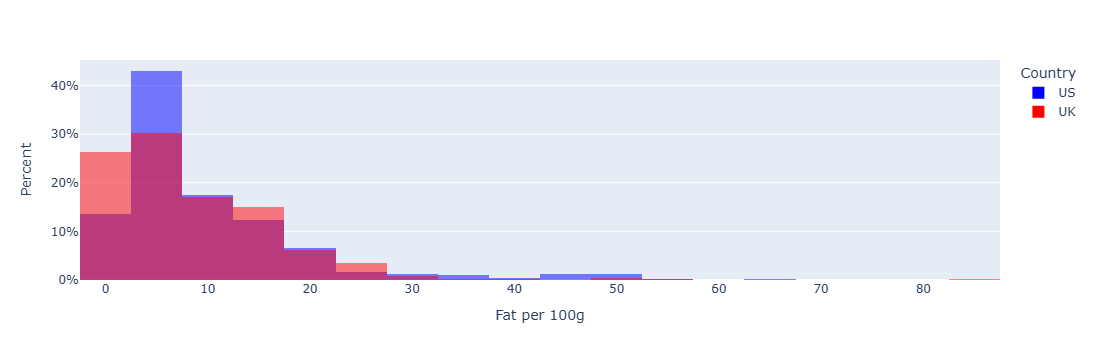

In [4]:
df = food_df[food_df['country'].isin(['united-states','united-kingdom'])].copy()
df = df[df['fat_100g'].between(0, 100, inclusive='both')]
df['country_label'] = df['country'].map({'united-states':'US', 'united-kingdom':'UK'})

fig = px.histogram(
    df, x='fat_100g', color='country_label',
    nbins=30, opacity=0.5, histnorm='percent'
)
fig.update_layout(barmode='overlay', xaxis_title='Fat per 100g', yaxis_title='Percent', legend_title='Country')
fig.update_yaxes(ticksuffix='%')
fig.for_each_trace(lambda t: t.update(marker_color={'US':'blue','UK':'red'}[t.name]))
fig.show()

Plot 2 - Histogram: Shows distribution of the amount of fat in the cereal with the y-axis being the percentages for each country.